In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../cvxportfolio'))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

plotdir = 'plots/'
datadir='data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]



#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers  = list(volumes.ix[:, (volumes > 0).all()].columns)[:30] + ["USDOLLAR"]
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2014-01-01"
end_t="2016-12-29"

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key='USDOLLAR')

return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()

return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]

optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., 
                                sigma=sigma_estimate, volume=volume_estimate)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()
#risk_data = pd.HDFStore(datadir+'risk_model.h5')
#risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)
risk_model = cp.FullSigma(Sigma_hat)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for 

In [3]:
all_return_estimates={}
n_p1=returns.shape[1]
T=returns.shape[0]

for i,t in enumerate(returns.index[:-1]):
    all_return_estimates[(t,t)]= return_estimate.loc[t]
    tp1=returns.index[i+1]
    all_return_estimates[(t,tp1)]=return_estimate.loc[tp1]
    
returns_forecast = cp.MPOReturnsForecast(all_return_estimates)
results_MPO={}

## MPO Coarse search 

In [4]:
policies={}
gamma_risks_coarse=[.1,.3,1, 3,10,30,100,300,1000]
gamma_tcosts_coarse=[1., 2., 5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse: 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.MultiPeriodOpt(return_forecast=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index),#[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)


In [5]:

results_MPO.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b*1e8, start_time = start_t, end_time=end_t, 
                                          policies=policies.values(),parallel=False))})

In [6]:
result_df_coarse=pd.DataFrame()
for k in results_MPO:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results_MPO[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

[33.53442907642934, 33.021190049105449, 31.454371468383989, 28.541196217430759, 23.025899487646161, 15.544207190755523, 9.400311969177821, 4.6960537192503287, 1.6072895487197572] [-39.282899656607285, -39.27399469855896, -39.144272175899495, -37.41065182654741, -32.38262387840694, -28.986625934980236, -25.358221652719475, -12.5771491597181, -2.687571376378174]
[25.352724974039901, 24.903509077260193, 23.660025756614612, 21.398219584334658, 16.962264210564314, 11.444065382173111, 7.3978076570344244, 3.4037923491755695, 1.2468716901624275] [2.1377111736836887, 2.7609131145432806, 4.322180604989919, 7.37461219633546, 6.793067125988994, -1.4233602417372762, -4.99098691200805, -2.0677533348395642, -0.17354652566263853]
[19.978965559315448, 19.349318328687488, 17.685144037926726, 14.991162622299816, 10.544836213983199, 7.6136538190070437, 3.9923985667898179, 1.9222763121818527, 0.79950105672404026] [27.02632174222053, 25.643026461893573, 22.587062574406477, 18.249428466969924, 12.52387277781

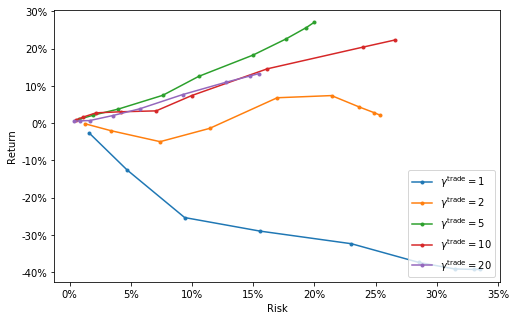

In [7]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

### Fine search

In [8]:
policies = {}

gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine: 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.MultiPeriodOpt(return_forecast=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index),#[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

results_MPO.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b*1e8, start_time = start_t, end_time=end_t, 
                                          policies=policies.values(),parallel=False))})

In [9]:
result_df_fine=pd.DataFrame()
for k in results_MPO:
    if k[0] in gamma_risks_fine and k[1] in gamma_tcosts_fine:
        result_df_fine.loc[k[0], k[1]] = results_MPO[k]
        
result_df = result_df_fine.loc[sorted(result_df_fine.index), sorted(result_df_fine.columns)]

[20.274836376123947, 19.799442157705503, 18.443751374052091, 16.209379380442481, 12.013559423634009, 8.4608719431631538, 4.8319198294046561, 2.2582947970030824, 0.90757287901717187] [25.729547199120354, 24.87142124815601, 23.284578618722303, 20.4541550954808, 15.379108946060924, 8.50585997972295, 3.2665310398217073, 1.9008541793152918, 0.9433233355677071]
[19.978967653590004, 19.349322851898627, 17.685143468874312, 14.991161616342266, 10.544835532960457, 7.6136529696338995, 3.9923984331767515, 1.9222761758280147, 0.79950108471766146] [27.026337197712074, 25.643046873252366, 22.58707099512188, 18.24941954656641, 12.523907928040645, 7.449012473546014, 3.7638443168507862, 2.1071683612306003, 1.0304475291971813]
[20.568637596608212, 19.532171546079017, 17.312917412065691, 13.753653527524609, 9.5132111067692708, 6.7904521452545881, 3.4030010381760758, 1.6657771451701273, 0.71103059301877725] [27.971727518022476, 26.41879275294174, 22.697339748790842, 15.725154063435873, 10.023210308701701, 

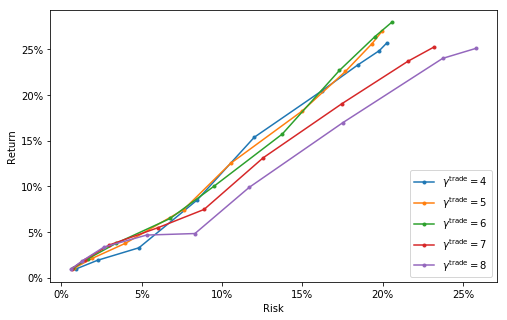

In [10]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

# MPO Pareto search 

In [12]:
1

1

In [13]:
results_pareto={}

In [14]:
policies={}
#gamma_risks_pareto=[int(round(el)) for el in np.logspace(0,3,13)]
gamma_risks_pareto=[1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[7,8,9,10,11,12]
gamma_holdings=[.1,1.,10., 100.,1000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = cp.MultiPeriodOpt(
                return_forecast=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, 
                                 gamma_holding*optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index),#[(returns.index>=start_t)&(returns.index<=end_t)]),
#                          trading_times=list(returns.index[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,
                                                                                end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [15]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]

table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv(datadir+'mpo_pareto_results_big_old.csv', float_format='%g')

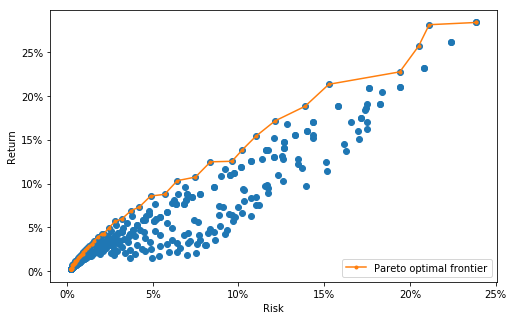

In [16]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'mpo_pareto.png')

In [17]:
xlim=20
ylim=30
tableprint=table[table.is_pareto]
tableprint=tableprint[tableprint.Risk <= xlim]
tableprint=tableprint[tableprint.Return <= ylim]
del tableprint['is_pareto']
tableprint.Risk=tableprint.Risk.apply(lambda x: '%.2f%%'%x)
tableprint.Return=tableprint.Return.apply(lambda x: '%.2f%%'%x)
print(tableprint.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

\begin{tabular}{rrlll}
\toprule
 $\gamma^\mathrm{risk}$ &  $\gamma^\mathrm{trade}$ & $\gamma^\mathrm{hold}$ &  Return &    Risk \\
\midrule
                   1000 &                       12 &                    100 &   0.23\% &   0.22\% \\
                   1000 &                       12 &                   1000 &   0.23\% &   0.22\% \\
                   1000 &                       11 &                    100 &   0.25\% &   0.23\% \\
                   1000 &                       11 &                   1000 &   0.25\% &   0.23\% \\
                   1000 &                       10 &                    100 &   0.27\% &   0.23\% \\
                   1000 &                       10 &                   1000 &   0.27\% &   0.23\% \\
                   1000 &                        9 &                    100 &   0.29\% &   0.24\% \\
                   1000 &                        8 &                    100 &   0.30\% &   0.25\% \\
                   1000 &                        7 &

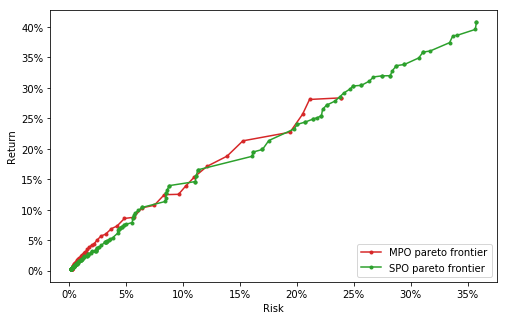

In [20]:
table_spo = pd.read_csv('data/spo_pareto_results_old.csv', index_col=0)

plt.figure(figsize=(8,5))

plt.plot(table[table.is_pareto].Risk, table[table.is_pareto].Return, 'C3.-', label='MPO pareto frontier')

plt.plot(table_spo[table_spo.is_pareto].Risk,
         table_spo[table_spo.is_pareto].Return, 'C2.-', label='SPO pareto frontier')
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

In [19]:
table

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk,is_pareto
0,1,7,1000,28.359146,23.877031,True
1,1,7,100,28.359143,23.877025,True
2,1,8,1000,26.105776,22.397168,False
3,1,8,100,26.105763,22.397165,False
4,1,7,10,28.102529,21.127877,True
5,1,9,1000,23.213724,20.839995,False
6,1,9,100,23.213722,20.839989,False
7,1,8,10,25.678048,20.516616,True
8,1,10,1000,20.967829,19.413896,False
9,1,10,100,20.967823,19.413896,False
